In [1]:
import os
import sys
sys.path.append("../../../")
import configs.config as config
import src.data.preprocessing.CICprep as CICprep
import src.data.preprocessing.botprep as botprep

In [2]:
import dgl.nn as dglnn
from dgl import from_networkx
import dgl.function as fn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import src.models.MLP as mlp
import torch as th
import torch.nn.functional as F
import networkx as nx
import src.utils.EGScommon as EGScommon
import sklearn
from sklearn.model_selection import train_test_split

In [3]:
device = os.environ.get("DEVICE", config.DEVICE)

In [4]:
X_A_train = botprep.X_train
X_A_test = botprep.X_test
y_A_train = botprep.y_train
y_A_test = botprep.y_test 

In [5]:
X_B_train = CICprep.X_train
X_B_test = CICprep.X_test
y_B_train = CICprep.y_train
y_B_test = CICprep.y_test 

In [6]:
G_A = nx.from_pandas_edgelist(X_A_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_A = G_A.to_directed()
G_A = from_networkx(G_A, edge_attrs=['h', 'label'])

In [7]:
G_A.ndata['h'] = th.ones(G_A.num_nodes(), G_A.edata['h'].shape[1])

In [8]:
G_A.edata['train_mask'] = th.ones(len(G_A.edata['h']), dtype=th.bool)

In [9]:
G_A.ndata['h'] = th.reshape(G_A.ndata['h'], (G_A.ndata['h'].shape[0], 1,G_A.ndata['h'].shape[1]))
G_A.edata['h'] = th.reshape(G_A.edata['h'], (G_A.edata['h'].shape[0], 1,G_A.edata['h'].shape[1]))

In [10]:
class_weights = EGScommon.EGScompute_class_weights(G_A)
class_weights = th.FloatTensor(class_weights).to(device)
criterion = th.nn.CrossEntropyLoss(weight=class_weights)

In [11]:
G_A = G_A.to(device)

In [12]:
node_features_bot = G_A.ndata['h']
edge_features_bot = G_A.edata['h']

edge_label_bot = G_A.edata['label']
train_mask_bot = G_A.edata['train_mask']

accuracies_bot = []
best_acc_bot = 0
best_model_state_bot = None
numclasses = len(y_A_train.value_counts())
current_epoch_bot = 0
epochs = []
model = mlp.Model(G_A.ndata['h'].shape[2], 128, G_A.ndata['h'].shape[2], F.relu, 0.2, numclasses).to(device)
opt = th.optim.Adam(model.parameters())

for epoch in range(1,100):
    pred = model(G_A, node_features_bot,edge_features_bot).to(device)
    loss = criterion(pred[train_mask_bot] ,edge_label_bot[train_mask_bot])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 10 == 0:
      current_epoch_bot += 10
      acc_bot = EGScommon.compute_accuracy(pred[train_mask_bot], edge_label_bot[train_mask_bot])
      accuracies_bot.append(acc_bot)
      epochs.append(current_epoch_bot)
      print('Task A (BoT-IoT) Training acc:', acc_bot)
      # Save the best model
      if acc_bot > best_acc_bot:
        best_acc_bot = acc_bot
        best_model_state_bot = model.state_dict()
        print(f'New best accuracy Task A (BoT-IoT): {best_acc_bot:.4f}')
        th.save(best_model_state_bot, config.PARAM_PATH)

Task A (BoT-IoT) Training acc: 0.9345608949661255
New best accuracy Task A (BoT-IoT): 0.9346
Task A (BoT-IoT) Training acc: 0.9389613270759583
New best accuracy Task A (BoT-IoT): 0.9390
Task A (BoT-IoT) Training acc: 0.9326587915420532
Task A (BoT-IoT) Training acc: 0.9297521710395813
Task A (BoT-IoT) Training acc: 0.9160853624343872
Task A (BoT-IoT) Training acc: 0.9171113967895508
Task A (BoT-IoT) Training acc: 0.9151224493980408
Task A (BoT-IoT) Training acc: 0.9148296117782593
Task A (BoT-IoT) Training acc: 0.9168221950531006


In [13]:
# Save Task A performance
th.save(best_model_state_bot, config.PARAM_PATH)
task_a_accuracy = best_acc_bot

In [14]:
# Evaluate Task A performance before Task B training
model.load_state_dict(th.load(config.PARAM_PATH))
with th.no_grad():
    test_pred_bot = model(G_A, node_features_bot, edge_features_bot).to(device)
    task_a_before = EGScommon.compute_accuracy(test_pred_bot[train_mask_bot], edge_label_bot[train_mask_bot])
print(f"Task A accuracy before Task B training: {task_a_before:.4f}")

Task A accuracy before Task B training: 0.9166


In [15]:
G_B = nx.from_pandas_edgelist(X_B_train, ' Source IP', ' Destination IP', ['h', 'label'],create_using=nx.MultiGraph())
G_B = G_B.to_directed()
G_B = from_networkx(G_B, edge_attrs=['h', 'label'])

In [16]:
G_B.ndata['h'] = th.ones(G_B.num_nodes(), G_B.edata['h'].shape[1])

In [17]:
G_B.edata['train_mask'] = th.ones(len(G_B.edata['h']), dtype=th.bool)

In [18]:
G_B.ndata['h'] = th.reshape(G_B.ndata['h'], (G_B.ndata['h'].shape[0], 1,G_B.ndata['h'].shape[1]))
G_B.edata['h'] = th.reshape(G_B.edata['h'], (G_B.edata['h'].shape[0], 1,G_B.edata['h'].shape[1]))

In [19]:
class_weights = EGScommon.EGScompute_class_weights(G_B)
class_weights = th.FloatTensor(class_weights).to(device)
criterion = th.nn.CrossEntropyLoss(weight=class_weights)

In [20]:
G_B = G_B.to(device)

In [21]:
node_features_cic = G_B.ndata['h']
edge_features_cic = G_B.edata['h']

edge_label_cic = G_B.edata['label']
train_mask_cic = G_B.edata['train_mask']

accuracies_cic = []
best_acc_cic = 0
epochs_cic = []
current_epoch_cic = 0
best_model_state_cic = None
numclasses_cic = len(y_B_train.value_counts())

model = mlp.Model(G_B.ndata['h'].shape[2], 128, G_B.ndata['h'].shape[2], F.relu, 0.2, numclasses_cic).to(device)
opt = th.optim.Adam(model.parameters())

for epoch in range(1,100):
    pred = model(G_B, node_features_cic,edge_features_cic).to(device)
    loss = criterion(pred[train_mask_cic] ,edge_label_cic[train_mask_cic])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 10 == 0:
      current_epoch_cic += 10
      acc_cic = EGScommon.compute_accuracy(pred[train_mask_cic], edge_label_cic[train_mask_cic])
      accuracies_cic.append(acc_cic)
      epochs_cic.append(current_epoch_cic)
      print('Task B (CIC-IDS) Training acc: ', acc_cic)
      # Save the best model
      if acc_cic > best_acc_cic:
        best_acc_cic = acc_cic
        best_model_state_cic = model.state_dict()
        print(f'New best accuracy Task B (CIC-IDS): {best_acc_cic:.4f}')

Task B (CIC-IDS) Training acc:  0.780460774898529
New best accuracy Task B (CIC-IDS): 0.7805
Task B (CIC-IDS) Training acc:  0.9044066667556763
New best accuracy Task B (CIC-IDS): 0.9044
Task B (CIC-IDS) Training acc:  0.9406290054321289
New best accuracy Task B (CIC-IDS): 0.9406
Task B (CIC-IDS) Training acc:  0.9446917772293091
New best accuracy Task B (CIC-IDS): 0.9447
Task B (CIC-IDS) Training acc:  0.9443643093109131
Task B (CIC-IDS) Training acc:  0.9559080004692078
New best accuracy Task B (CIC-IDS): 0.9559
Task B (CIC-IDS) Training acc:  0.960206151008606
New best accuracy Task B (CIC-IDS): 0.9602
Task B (CIC-IDS) Training acc:  0.9657272696495056
New best accuracy Task B (CIC-IDS): 0.9657
Task B (CIC-IDS) Training acc:  0.9670064449310303
New best accuracy Task B (CIC-IDS): 0.9670


In [22]:
with th.no_grad():
    test_pred_bot = model(G_A, node_features_bot, edge_features_bot).to(device)
    task_a_after = EGScommon.compute_accuracy(test_pred_bot[train_mask_bot], edge_label_bot[train_mask_bot])
print(f"Task A accuracy after Task B training: {task_a_after:.4f}")


Task A accuracy after Task B training: 0.1959


In [23]:
# Show catastrophic forgetting effect
print("\nCatastrophic Forgetting Analysis:")
print(f"Task A accuracy before Task B: {task_a_before:.4f}")
print(f"Task A accuracy after Task B:  {task_a_after:.4f}")
print(f"Performance drop: {(task_a_before - task_a_after):.4f}")


Catastrophic Forgetting Analysis:
Task A accuracy before Task B: 0.9166
Task A accuracy after Task B:  0.1959
Performance drop: 0.7207


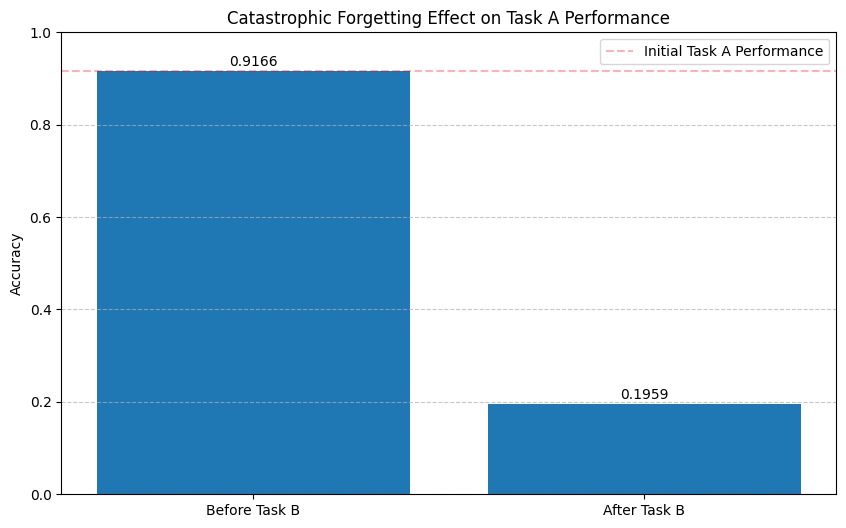

<Figure size 640x480 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt

# Create figure with specified size
plt.figure(figsize=(10, 6))

# Create bar plot
plt.bar(['Before Task B', 'After Task B'], [task_a_before, task_a_after])

# Customize the plot
plt.title('Catastrophic Forgetting Effect on Task A Performance')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis from 0 to 1 since we're dealing with accuracy

# Add value labels on top of each bar
for i, v in enumerate([task_a_before, task_a_after]):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Optionally add a horizontal line at initial performance for reference
plt.axhline(y=task_a_before, color='r', linestyle='--', alpha=0.3, label='Initial Task A Performance')

# Add legend
plt.legend()

# Show the plot
plt.show()

# Optionally save the plot
plt.savefig('catastrophic_forgetting.png')